In [3]:
import numpy as np
import pandas as pd
from scipy import signal as sg
from scipy.fft import fftshift
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

# import matplotlib.pyplot as plt
# %matplotlib inline
# import mpld3
# mpld3.enable_notebook()

In [4]:
def find_first_local_min_below_threshold(array, threshold):
    """
    Finds the index of the first local minima in an array below a given threshold.  

    Parameters:
    - array (ndarray): Input array to search for local minima.
    - threshold (float): Threshold value for the first local minima.  
    
    Returns:
    - index (int): Index of the first local minima below the threshold. Returns None if no such minima found.
    """
    local_minima_indices = sg.argrelmin(array)[0]
    for index in local_minima_indices:
        if array[index] < threshold:
            return index
    return None

def parabolic_interp(prev, max, next):
    """
    Performs parabolic interpolation to estimate the exact x position of the local minima.

    Parameters:
    - prev (float): Value before the local minima.
    - max (float): Value at the local minima.
    - next (float): Value after the local minima.

    Returns:
    - x_max (float): Estimated x position of the local minima.
    """
    numerator = prev - next
    denominator = prev - 2 * max + next
    
    x_max = 0.5 * numerator / denominator
    
    return x_max

def difference_vectorized(x, W, max_tau):
    """
    Calculates the difference vector for pitch detection.

    Parameters:
    - x (ndarray): Input array.
    - W (int): Window size.
    - max_tau (int): Maximum tau value.

    Returns:
    - diff (ndarray): Difference vector.
    """
    diff = [0] * (max_tau + 1)
    for tau in range(max_tau + 1):
        diff[tau] = np.sum((x[1:W-tau] - x[1+tau:W])**2)
    return diff

# Function that calculates the cumulative mean normalized difference function.
def computeCmndf(x, W, min_tau, max_tau):
    """
    Computes the Cumulative Mean Normalized Difference Function (CMNDF) for pitch detection.

    Parameters:
    - x (ndarray): Input array.
    - W (int): Window size.
    - min_tau (int): Minimum delay value.
    - max_tau (int): Maximum delay value.

    Returns:
    - cmndf (ndarray): Cumulative Mean Normalized Difference Function.
    """
    cmndf = np.empty(max_tau - min_tau)
    diff = difference_vectorized(x, W, max_tau)
    for tau in range(min_tau, max_tau):
        if tau == 0:
            cmndf[tau - min_tau] = 1.0
        else:
            sum = np.sum(diff[1:tau+1])
            cmndf[tau - min_tau] = diff[tau] / (sum / tau)
    return cmndf

def pitchDetect(audio, fs, min_f0, max_f0, W = 256, decimation_factor = 8, cmndf_threshold = 0.4):
    """
    Performs pitch detection on an audio signal.

    Parameters:
    - audio (ndarray): Input audio signal.
    - fs (int): Sampling frequency of the audio signal.
    - min_f0 (float): Minimum fundamental frequency (in Hz) to detect.
    - max_f0 (float): Maximum fundamental frequency (in Hz) to detect.
    - W (int): Window size for processing.
    - decimation_factor (int): Factor to downsample the audio signal for processing.
    - cmndf_threshold (float): Threshold for finding local minima in the Cumulative Mean Normalized Difference Function (CMNDF).

    Returns:
    - f0 (ndarray): Array of estimated pitch values corresponding to each frame in the audio signal. None values indicate no pitch detected.
    """
    f0 = []

    downsampled_audio = sg.decimate(audio, decimation_factor, zero_phase=True)
    downsampled_fs = fs // decimation_factor

    min_tau = int(downsampled_fs // max_f0)
    max_tau = int(downsampled_fs // min_f0)

    length = (len(downsampled_audio) // (W//2) - 1) * (W//2)

    for start in range(0, length , W//2):
      x = downsampled_audio[start:start+W]
      if (len(x) != W):
        break
      cmndf = computeCmndf(x, W, min_tau, max_tau)
      predicted_tau = find_first_local_min_below_threshold(cmndf, cmndf_threshold)
      if predicted_tau != None:
        interp_add = parabolic_interp(cmndf[predicted_tau - 1], cmndf[predicted_tau], cmndf[predicted_tau + 1])
        delay = min_tau + predicted_tau + interp_add
        res = downsampled_fs / delay
        f0.append(res)
      else:
        f0.append(None)
    return np.array(f0)

# Plot of the pitch estimation over the spectrogram
def plot_pitch_estimation(audio, fs, f0, min_f0, max_f0, decimation_factor = 8, W = 256, window_type = 'hamming'):
    decimation_factor = 8
    
    downsampled_fs = fs // decimation_factor
    window = sg.get_window(window_type, W * decimation_factor)
    print(f'W: {W}, decimation_factor:{decimation_factor}')
    print(f'window.shape: {window.shape}')
    plt.rcParams.update({"axes.grid" : False})
    frequencies, times, spectrogram = sg.spectrogram(audio, fs, window = window)
    plt.figure(figsize=(8, 4))
    plt.pcolormesh(times, frequencies, 10 * np.log10(spectrogram))
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar(label='Power Spectral Density (dB)')
    plt.plot(np.arange(0, len(f0) * (W//2), (W//2))/downsampled_fs, f0, c='r', label="RR Pred. (Hz)")
    plt.ylim(min_f0, max_f0)
    plt.xlim(0, (len(f0) - 2) * (W//2) / downsampled_fs)

    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Spectrogram and pitch estimation of the input a_y signal')
    plt.legend()

    time = np.arange(0, len(f0) * (W//2), (W//2))/downsampled_fs
    
    return time, f0

In [5]:
def butter_filter(data, cutoff=0.33, fs=50, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = sg.butter(order, normal_cutoff, btype="low", analog=False)
    return sg.filtfilt(b, a, data)

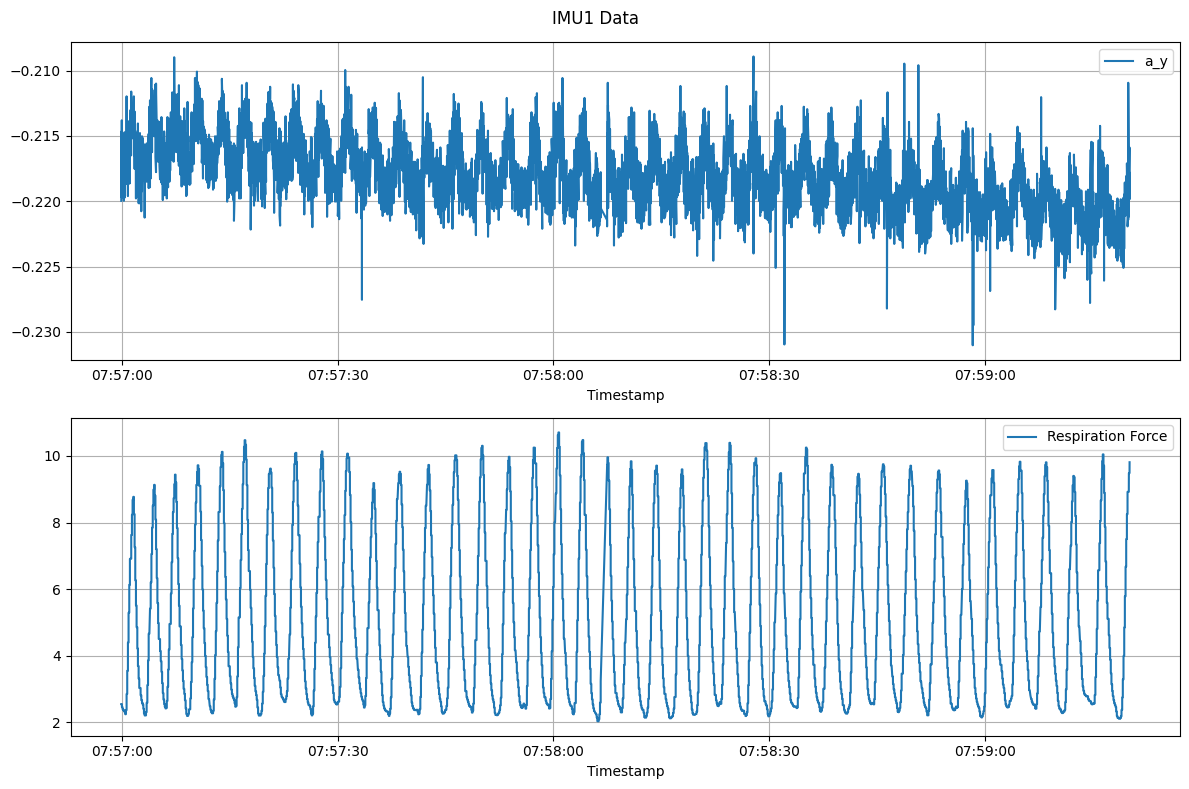

In [6]:
file_path = "data/old_data/imu_rr/0903_0756.csv" #0903_0756, 0903_0800, 0903_0802, 0903_0803, 0903_0805, 0905_0306

data = pd.read_csv(file_path)
data.columns = [
    "timestamp",
    "imu1_a_x",
    "imu1_a_y",
    "imu1_a_z",
    "imu1_g_x",
    "imu1_g_y",
    "imu1_g_z",
    "force",
    "respr",
]
data["timestamp"] = pd.to_datetime(data["timestamp"])
data["imu1_a_y"] = data["imu1_a_y"] / 65536
# data["imu1_a_y"] = data["imu1_a_y"] - np.mean(data["imu1_a_y"])
data = data.set_index("timestamp")


fig, axs = plt.subplots(2, 1, figsize=(12, 8))
plt.suptitle("IMU1 Data")

plt.subplot(2, 1, 1)
plt.plot(data.index, data["imu1_a_y"], label="a_y")
# plt.plot(data["timestamp"], data["imu1_g_z"], label="IMU1 A Z Smoothed")
plt.xlabel("Timestamp")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.subplot(2, 1, 2)
plt.plot(data.index, data["force"], label="Respiration Force")
# plt.plot(data["timestamp"], data["imu1_g_z"], label="IMU1 A Z Smoothed")
plt.xlabel("Timestamp")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

W: 256, decimation_factor:8
window.shape: (2048,)
[  0.  16.  32.  48.  64.  80.  96. 112.]
[0.27860446 0.25510752 0.24722511 0.26308272 0.26993461 0.2621858
 0.24952712 0.24353836]


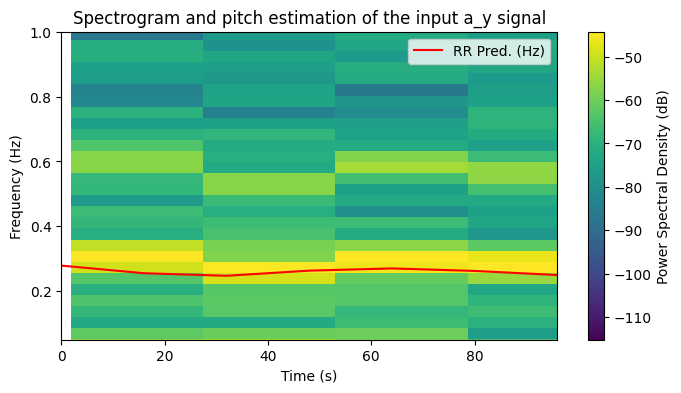

In [7]:
fs = 70

# Mezzo soprano vocal range
min_f0 = 0.05
max_f0 = int(1) # F5

f0 = pitchDetect(data["imu1_a_y"], fs, min_f0, max_f0)
time_f0, f0 = plot_pitch_estimation(data["imu1_a_y"], fs, f0, min_f0, max_f0)
# ipd.Audio(audio, rate=fs)
print(time_f0)
print(f0)

In [8]:
peaks, _ = sg.find_peaks(data["force"], height=6, distance=np.median(data["force"]))
print(peaks)

[ 182  385  588  810 1046 1268 1513 1765 2020 2268 2523 2777 3058 3320
 3580 3842 4084 4326 4561 4773 5032 5277 5528 5759 5993 6244 6490 6737
 6986 7247 7484 7756 8031 8299 8555 8822 9076 9344 9631]


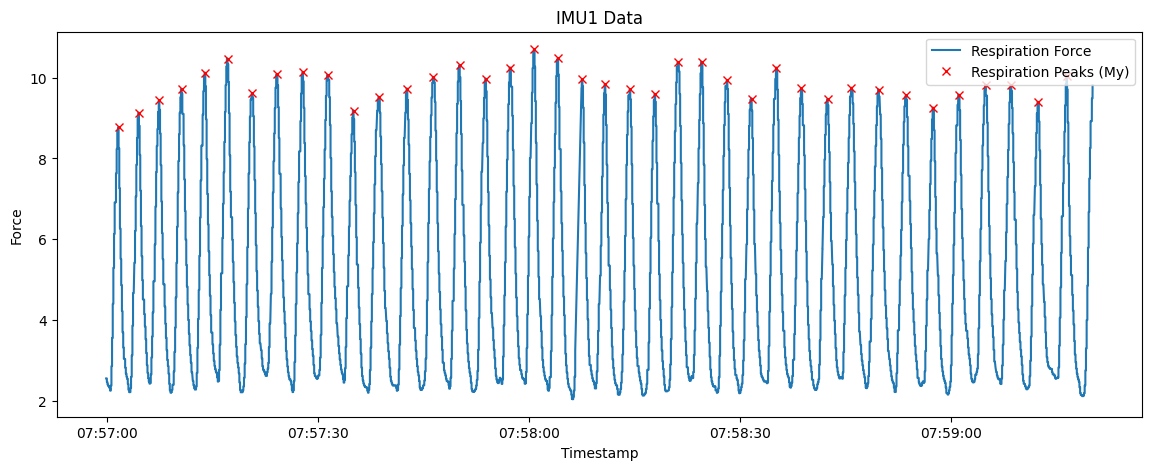

In [9]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 1, 1)
plt.plot(
    data.index,
    data["force"],
    label="Respiration Force", # IMU1 RMS
)

plt.plot(
    data.index[peaks],
    data["force"].iloc[peaks],
    "x",
    c='r',
    label="Respiration Peaks (My)",
)

plt.title("IMU1 Data")
plt.xlabel("Timestamp")
plt.ylabel("Force")
plt.legend()

plt.show()

In [10]:
gt = np.zeros(len(data["force"]))
gt_disctete = []
for i in range(len(peaks) - 1):
    current_time_delta = data.index[peaks[i + 1]] - data.index[peaks[i]]
    current_time_delta = current_time_delta.total_seconds()
    RR = (1 / current_time_delta) * 60
    gt[peaks[i]:peaks[i + 1]] = RR
    gt_disctete.append(RR)

    # print(f'i:{i}, RR:{RR}')

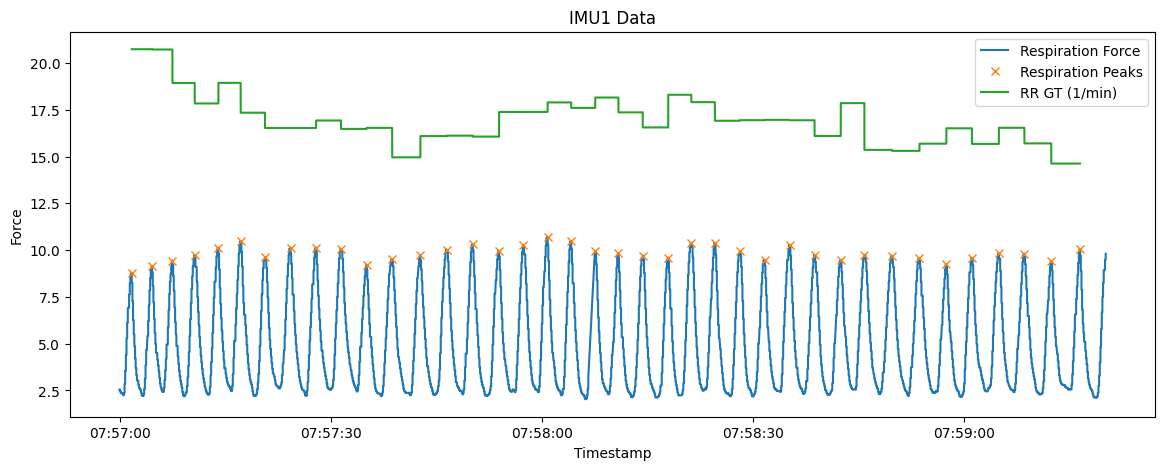

In [11]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 1, 1)
plt.plot(
    data.index,
    data["force"],
    label="Respiration Force", # IMU1 RMS
)

plt.plot(
    data.index[peaks],
    data["force"].iloc[peaks],
    "x",
    label="Respiration Peaks",
)

plt.plot(
    data.index[peaks[0]:peaks[-1]],
    gt[peaks[0]:peaks[-1]],
    label="RR GT (1/min)", # IMU1 RMS
)

plt.title("IMU1 Data")
plt.xlabel("Timestamp")
plt.ylabel("Force")
plt.legend()

plt.show()

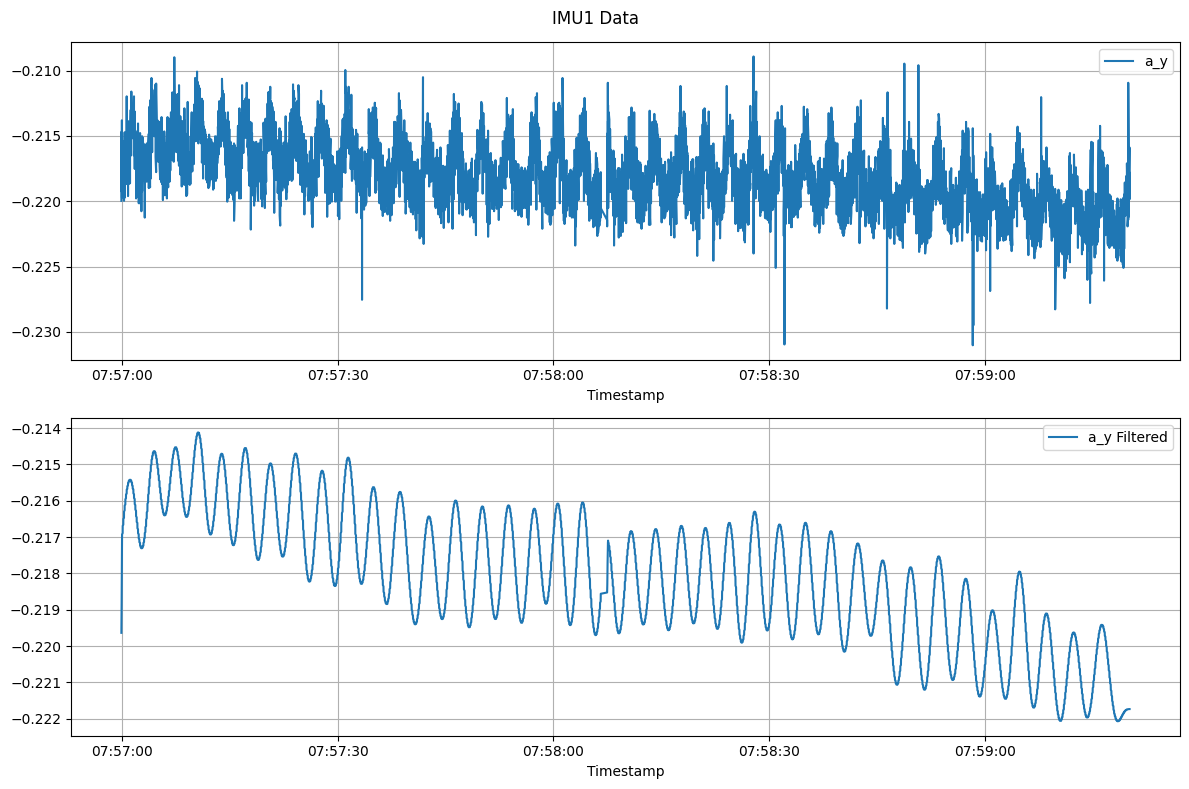

In [12]:
a_y_filtered = butter_filter(data["imu1_a_y"], 0.33, 70)

fig, axs = plt.subplots(2, 1, figsize=(12, 8))
plt.suptitle("IMU1 Data")

plt.subplot(2, 1, 1)
plt.plot(data.index, data["imu1_a_y"], label="a_y")
# plt.plot(data["timestamp"], data["imu1_g_z"], label="IMU1 A Z Smoothed")
plt.xlabel("Timestamp")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.subplot(2, 1, 2)
plt.plot(data.index, a_y_filtered , label="a_y Filtered")
# plt.plot(data["timestamp"], data["imu1_g_z"], label="IMU1 A Z Smoothed")
plt.xlabel("Timestamp")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

(9890,)


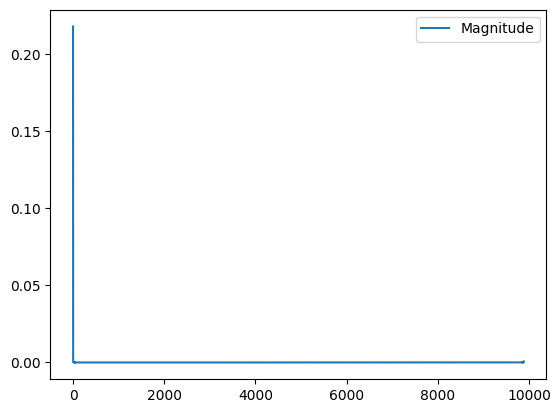

In [13]:
f_ay_filtered = np.fft.ifft(a_y_filtered)
t = np.arange(len(f_ay_filtered))

print(f_ay_filtered.shape)
# plt.plot(t, f_ay_filtered.real, label='real')
# plt.plot(t, f_ay_filtered.imag, '--', label='imaginary')
plt.plot(t, abs(f_ay_filtered), label='Magnitude')
plt.legend()
plt.show()

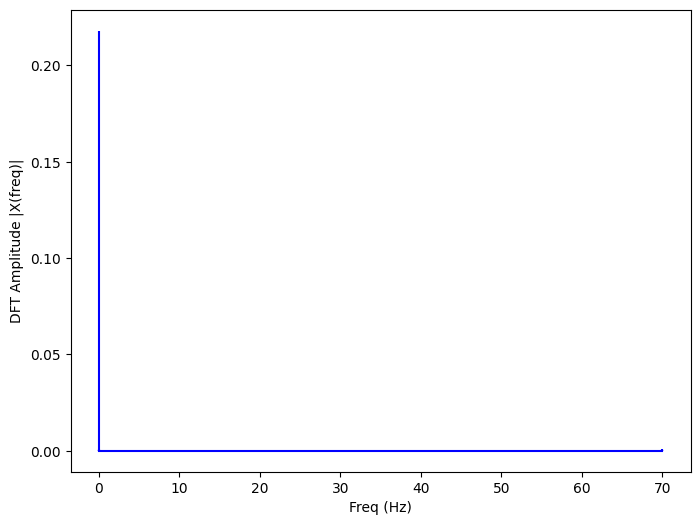

In [14]:
# calculate the frequency
N = len(f_ay_filtered)
n = np.arange(N)
T = N/70
freq = n/T 

plt.figure(figsize = (8, 6))
plt.stem(freq, abs(f_ay_filtered), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('DFT Amplitude |X(freq)|')
plt.show()

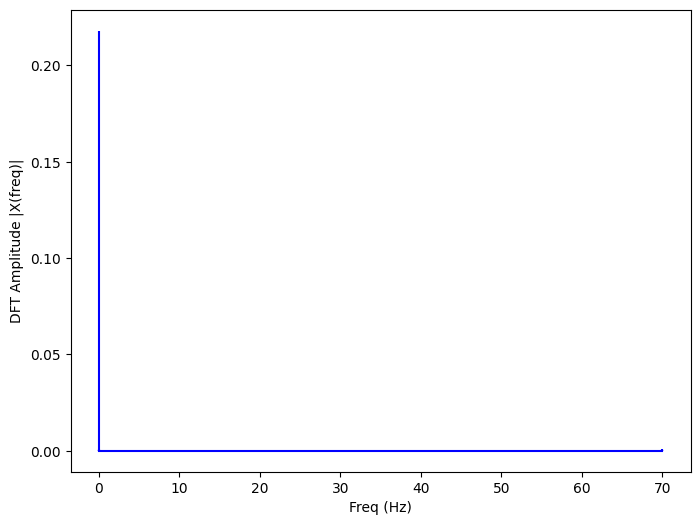

In [15]:
f_ay = np.fft.ifft(data["imu1_a_y"])

N = len(f_ay)
n = np.arange(N)
T = N/70
freq = n/T 

plt.figure(figsize = (8, 6))
plt.stem(freq, abs(f_ay), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('DFT Amplitude |X(freq)|')
plt.show()

In [16]:
f_pred_fft = 0.283 * 60
diff = gt[peaks[0]:peaks[-1]] - f_pred_fft
diff_abs = abs(diff)
np.average(diff_abs)

np.float64(0.9863380865710837)

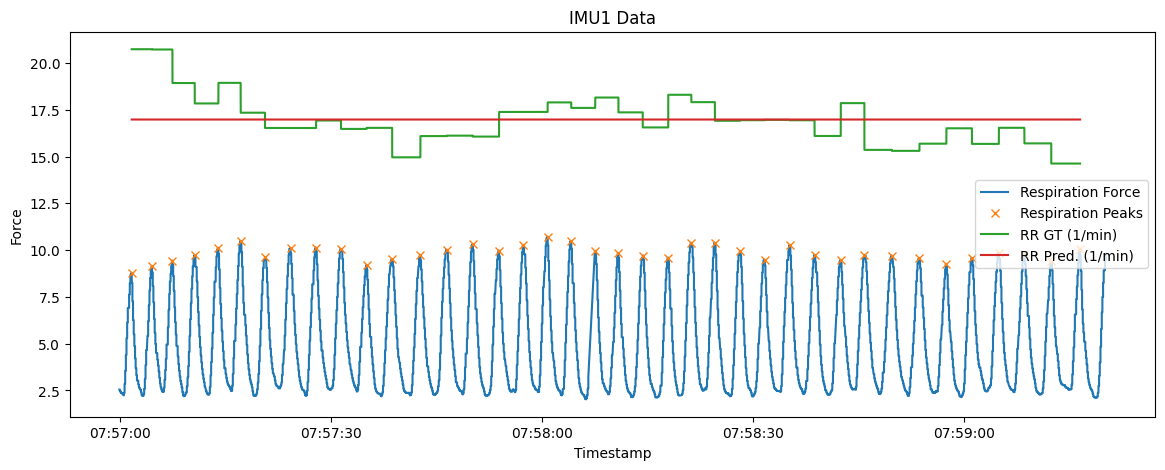

In [17]:
f_pred_fft_ls = np.full((peaks[-1] - peaks[0]), f_pred_fft)

plt.figure(figsize=(14, 5))
plt.subplot(1, 1, 1)
plt.plot(
    data.index,
    data["force"],
    label="Respiration Force", # IMU1 RMS
)

plt.plot(
    data.index[peaks],
    data["force"].iloc[peaks],
    "x",
    label="Respiration Peaks",
)

plt.plot(
    data.index[peaks[0]:peaks[-1]],
    gt[peaks[0]:peaks[-1]],
    label="RR GT (1/min)", # IMU1 RMS
)

plt.plot(
    data.index[peaks[0]:peaks[-1]],
    f_pred_fft_ls,
    label="RR Pred. (1/min)", # IMU1 RMS
)

plt.title("IMU1 Data")
plt.xlabel("Timestamp")
plt.ylabel("Force")
plt.legend()

plt.show()

# YIN

In [18]:
time_ls = data.index - data.index[0]
time_ls = time_ls.total_seconds()
time_ls

Index([       0.0,   0.002283,   0.004423,    0.00651,   0.008647,    0.01079,
         0.012945,   0.014974,   0.017105,   0.019168,
       ...
       140.106336, 140.108846, 140.111143, 140.194113,  140.19662, 140.199016,
       140.201432, 140.203802, 140.206528, 140.208907],
      dtype='float64', name='timestamp', length=9890)

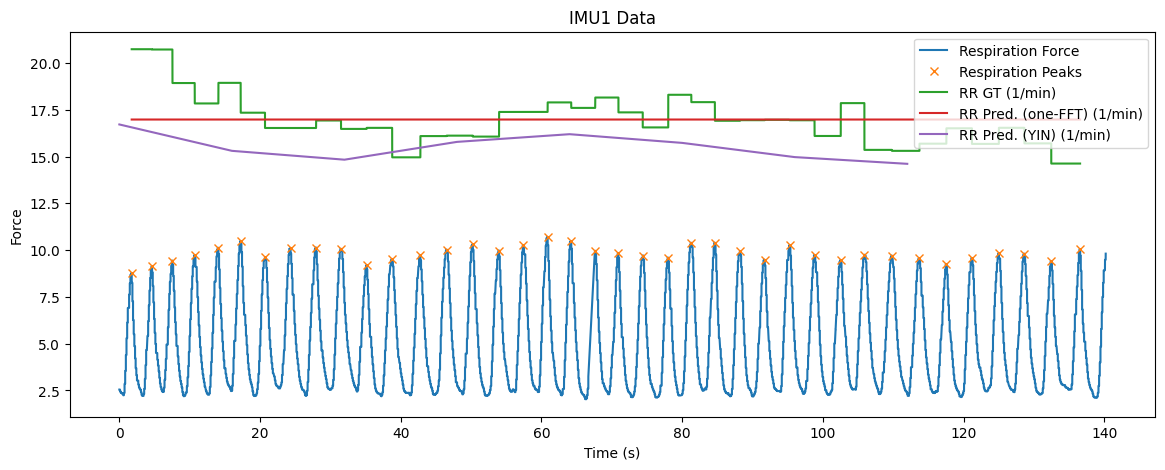

In [19]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 1, 1)
plt.plot(
    time_ls,
    data["force"],
    label="Respiration Force", # IMU1 RMS
)

plt.plot(
    time_ls[peaks],
    data["force"].iloc[peaks],
    "x",
    label="Respiration Peaks",
)

plt.plot(
    time_ls[peaks[0]:peaks[-1]],
    gt[peaks[0]:peaks[-1]],
    label="RR GT (1/min)",
)

plt.plot(
    time_ls[peaks[0]:peaks[-1]],
    f_pred_fft_ls,
    label="RR Pred. (one-FFT) (1/min)",
)

plt.plot(
    time_f0,
    f0 * 60,
    label="RR Pred. (YIN) (1/min)",
)

plt.title("IMU1 Data")
plt.xlabel("Time (s)")
plt.ylabel("Force")
plt.legend(loc='upper right')

plt.show()

In [20]:
f_pred_fft = 0.283 * 60
diff = gt[peaks[0]:peaks[-1]] - f_pred_fft
diff_abs = abs(diff)
np.average(diff_abs)

np.float64(0.9863380865710837)

In [21]:
idx_t_f0_2_t_ls = []

idx_f0 = 0
for i in range(len(time_ls)):
    if  time_f0[idx_f0] <= time_ls[i]:
        idx_t_f0_2_t_ls.append(i)
        idx_f0 += 1
        
    if idx_f0 >= len(f0):
        break

In [22]:
diff_YIN = []

for i in range(len(f0) - 1):
    idx_t = idx_t_f0_2_t_ls[i]
    while idx_t < idx_t_f0_2_t_ls[i+1]:
        f_pred = 60 * (f0[i] + (f0[i+1] - f0[i]) * ((idx_t - idx_t_f0_2_t_ls[i]) / (idx_t_f0_2_t_ls[i+1] - idx_t_f0_2_t_ls[i])))

        if peaks[0] <= idx_t and idx_t <= peaks[-1]:
            diff_YIN.append(gt[idx_t] - f_pred)
            
        idx_t += 1

In [23]:
diff_YIN_abs = abs(np.array(diff_YIN))
print(np.average(diff_YIN_abs))

1.7302990909885452


# Spectrogram

In [24]:
fs = 70

W: 256, decimation_factor:4
window.shape: (1024,)
frequencies: (513,), times: (70,)


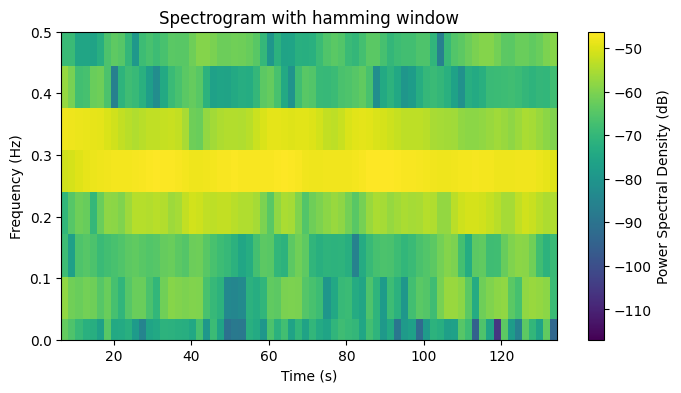

In [25]:
min_f0 = 0
max_f0 = 0.5
decimation_factor = 4 # 8
W = 256 # 256
window_type = 'hamming'
downsampled_fs = fs // decimation_factor
window = sg.get_window(window_type, W * decimation_factor)

print(f'W: {W}, decimation_factor:{decimation_factor}')
print(f'window.shape: {window.shape}')
plt.rcParams.update({"axes.grid" : False})
frequencies, times, spectrogram = sg.spectrogram(data["imu1_a_y"], fs, window = window, noverlap=window.shape[0] // 8 * 7)
plt.figure(figsize=(8, 4))
plt.pcolormesh(times, frequencies, 10 * np.log10(spectrogram))
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Power Spectral Density (dB)')
# plt.plot(np.arange(0, len(f0) * (W//2), (W//2))/downsampled_fs, f0, c='r', label="RR Pred. (Hz)")
plt.ylim(min_f0, max_f0)
# plt.xlim(0, (len(f0) - 2) * (W//2) / downsampled_fs)

print(f'frequencies: {frequencies.shape}, times: {times.shape}')

plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram with hamming window')
# plt.legend()
plt.show()

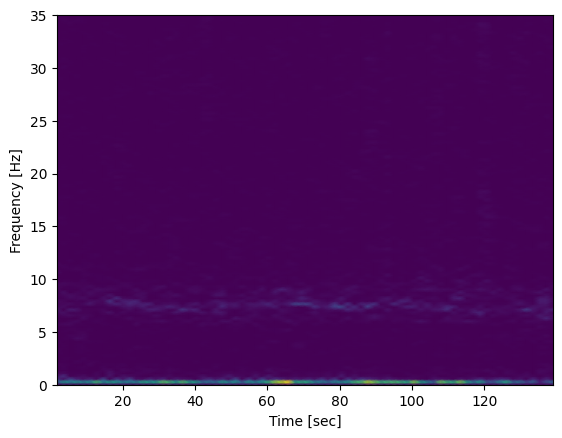

t.shape=(76,), f.shape=(129,), Sxx.shape=(129, 76)


In [26]:
# f, t, Sxx = signal.spectrogram(data["imu1_a_y"], fs, nperseg=fs//2, nfft=512)
f, t, Sxx = sg.spectrogram(data["imu1_a_y"], fs, noverlap=256//2)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()
print(f't.shape={t.shape}, f.shape={f.shape}, Sxx.shape={Sxx.shape}') # Sxx.shape = (f.shape, t.shape)

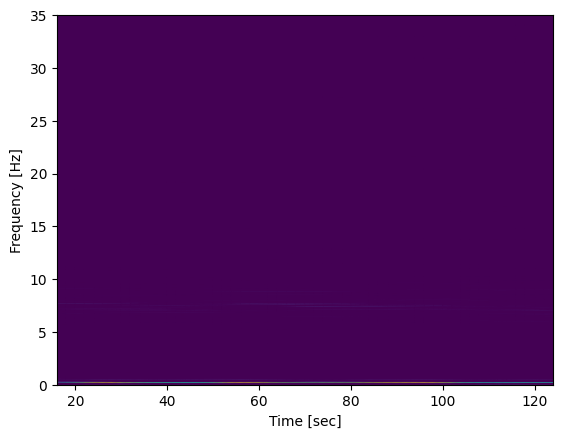

t_spec.shape=(55,), f_spec.shape=(1121,), Sxx.shape=(1121, 55)


In [27]:
# f, t, Sxx = signal.spectrogram(data["imu1_a_y"], fs, nperseg=fs//2, nfft=512)
# f, t, Sxx = sg.spectrogram(data["imu1_a_y"], fs, noverlap=256//2)
f_spec, t_spec, Sxx = sg.spectrogram(data["imu1_a_y"], fs, nperseg=fs * 32, noverlap=fs * 30) # 32 30
plt.pcolormesh(t_spec, f_spec, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()
print(f't_spec.shape={t_spec.shape}, f_spec.shape={f_spec.shape}, Sxx.shape={Sxx.shape}') # Sxx.shape = (f.shape, t.shape)

In [28]:
RR_pred_spectro_arg = np.argmax(Sxx, axis=0)
RR_pred_spectro = RR_pred_spectro_arg * (fs / 2 / f_spec.shape[0]) + (fs / 2 / f_spec.shape[0] / 2)

In [29]:
t_spec_draw = []
f_spec_draw = []

t_spec_draw.append(0)
f_spec_draw.append(RR_pred_spectro[0] * 60)

for i in range(t_spec.shape[0]):
    t_spec_draw.append(t_spec[i])
    f_spec_draw.append(RR_pred_spectro[i] * 60)
    
    if i < t_spec.shape[0] - 1:
        t_spec_draw.append(t_spec[i])
        f_spec_draw.append(RR_pred_spectro[i+1] * 60)

len(t_spec_draw)

110

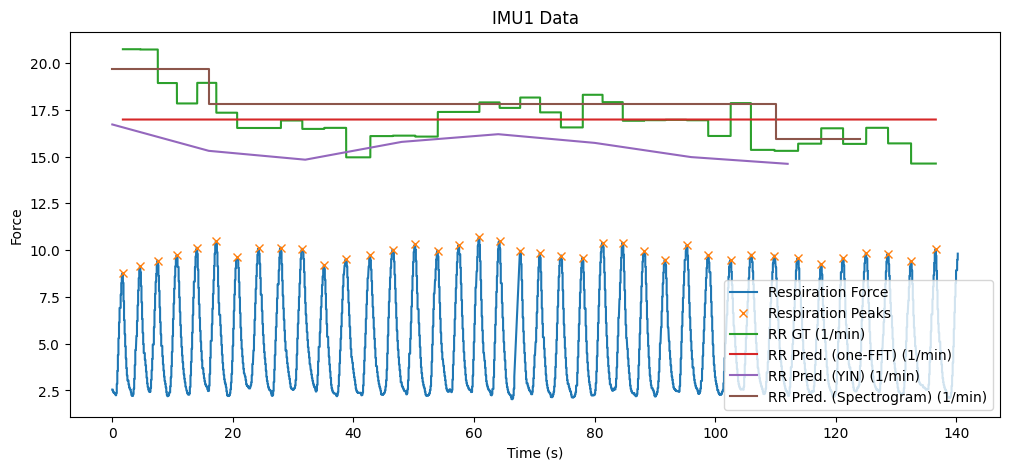

In [30]:
f_pred_fft_ls = np.full((peaks[-1] - peaks[0]), f_pred_fft)

plt.figure(figsize=(12, 5))
# plt.figure(figsize=(12, 3))
plt.subplot(1, 1, 1)
plt.plot(
    time_ls,
    data["force"],
    label="Respiration Force", # IMU1 RMS
)

plt.plot(
    time_ls[peaks],
    data["force"].iloc[peaks],
    "x",
    label="Respiration Peaks",
)

plt.plot(
    time_ls[peaks[0]:peaks[-1]],
    gt[peaks[0]:peaks[-1]],
    label="RR GT (1/min)",
)

plt.plot(
    time_ls[peaks[0]:peaks[-1]],
    f_pred_fft_ls,
    label="RR Pred. (one-FFT) (1/min)",
)

plt.plot(
    time_f0,
    f0 * 60,
    label="RR Pred. (YIN) (1/min)",
)

plt.plot(
    t_spec_draw,
    f_spec_draw,
    label="RR Pred. (Spectrogram) (1/min)",
)

plt.title("IMU1 Data")
plt.xlabel("Time (s)")
plt.ylabel("Force")
plt.legend(loc='lower right')

plt.show()

In [31]:
idx_t_spec_2_t_ls = []

idx_t_spec = 0
for i in range(len(time_ls)):
    if  t_spec[idx_t_spec] <= time_ls[i]:
        idx_t_spec_2_t_ls.append(i)
        idx_t_spec += 1
        
    if idx_t_spec >= len(t_spec):
        break

In [32]:
def calculate_err(time_gt, rr_gt, peaks, time_pred, rr_pred):
    time_peaks_gt = time_gt[peaks]
    # print(time_peaks_gt)
    # print(time_pred)

    idx_t_pred_2_t_gt_ls = []
    idx_t_pred = 0
    for i in range(len(time_gt)):
        if  time_pred[idx_t_pred] <= time_gt[i]:
            idx_t_pred_2_t_gt_ls.append(i)
            idx_t_pred += 1
            
        if idx_t_pred >= len(time_pred):
            break

    diff = []
    idx_t = 0
    
    for i in range(len(time_pred) - 1): # 捨棄最後一個rr_pred
        while idx_t < idx_t_pred_2_t_gt_ls[i+1]:
    
            if peaks[0] <= idx_t and idx_t <= peaks[-1]:
                diff.append(rr_gt[idx_t] - rr_pred[i])
                
            idx_t += 1

    diff_abs = abs(np.array(diff))
    
    return np.average(diff_abs)

In [33]:
err_spec = calculate_err(time_ls, gt, peaks, t_spec, RR_pred_spectro * 60)
print(err_spec)

1.010790775523569


In [34]:
diff_sepc = []
idx_t = 0

for i in range(len(t_spec) - 1): 
    while idx_t < idx_t_spec_2_t_ls[i+1]:
        f_pred = 60 * RR_pred_spectro[i]

        if peaks[0] <= idx_t and idx_t <= peaks[-1]:
            diff_sepc.append(gt[idx_t] - f_pred)
            
        idx_t += 1

In [35]:
diff_sepc_abs = abs(np.array(diff_sepc))
print(np.average(diff_sepc_abs))

1.010790775523569


# Auto-Correlation

In [36]:
def butter_filter(data, cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = sg.butter(order, normal_cutoff, btype='lp', analog=False)
    data = data.values if isinstance(data, pd.Series) else data
    return sg.filtfilt(b, a, data, axis=0)

In [37]:
data_a_y_filtered = butter_filter(data['imu1_a_y'], 1, 70) # 25

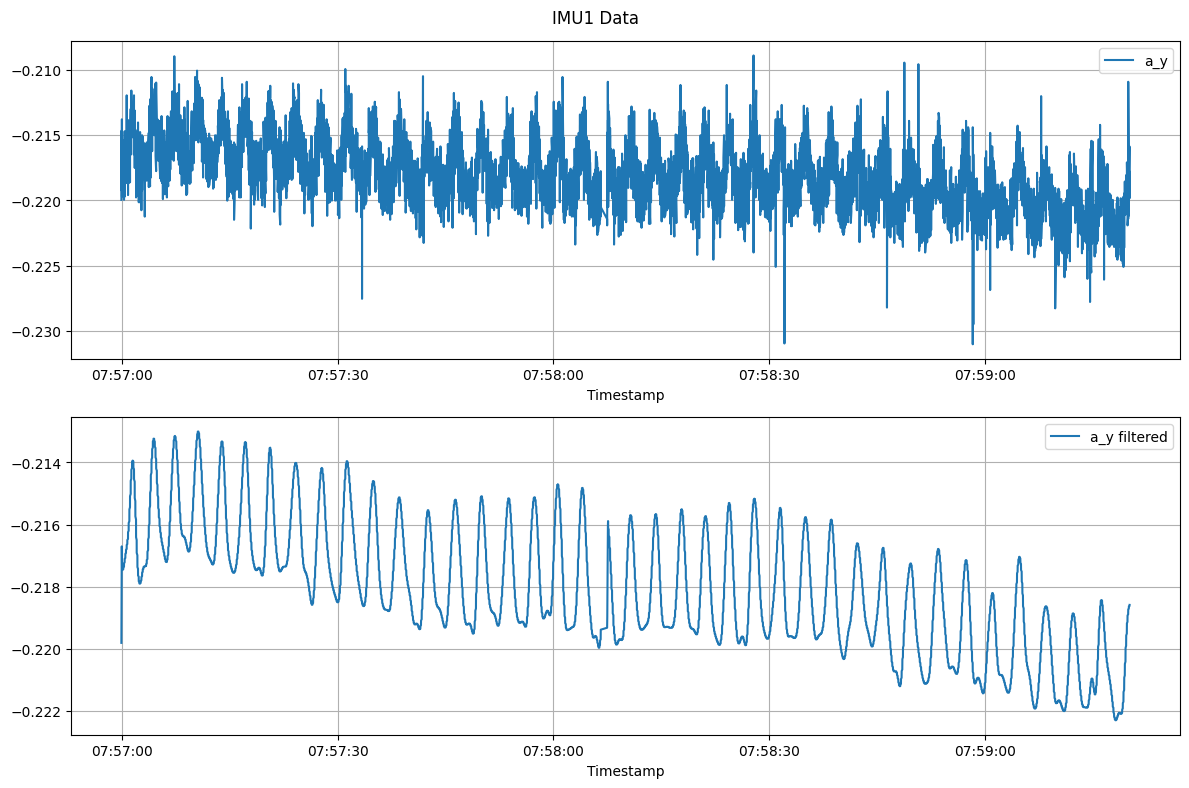

In [38]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
plt.suptitle("IMU1 Data")

plt.subplot(2, 1, 1)
plt.plot(data.index, data["imu1_a_y"], label="a_y")
# plt.plot(data["timestamp"], data["imu1_g_z"], label="IMU1 A Z Smoothed")
plt.xlabel("Timestamp")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.subplot(2, 1, 2)
plt.plot(data.index, data_a_y_filtered, label="a_y filtered")
# plt.plot(data["timestamp"], data["imu1_g_z"], label="IMU1 A Z Smoothed")
plt.xlabel("Timestamp")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [39]:
sampling_frequency = 70
T = 1/sampling_frequency # Sampling period
N = len(time_ls) # Signal length in samples
n = 15 * sampling_frequency # lag
t = N / sampling_frequency # Signal length in seconds
print(f'f_s :{sampling_frequency}, T:{T}, N:{N}, n:{n}, t:{t}')

f_s :70, T:0.014285714285714285, N:9890, n:1050, t:141.28571428571428


In [40]:
frame_size = 15 * sampling_frequency
overlap = 5 * sampling_frequency
frame_num = int((N - frame_size) / (frame_size - overlap)) + 1
freq_ls1, freq_ls2 = [], []
clarity_ls1, clarity_ls2 = [], []
time_acf_ls = []

print(f'frame_size:{frame_size}, overlap:{overlap}, frame_num:{frame_num}')

frame_size:1050, overlap:350, frame_num:13


In [41]:
for i in range(frame_num):
    frame_start = i * (frame_size - overlap)
    
    # frame_segment1 = data["imu1_a_y"][frame_start:frame_start+frame_size]
    frame_segment1 = data['imu1_a_y'][frame_start:frame_start+frame_size]
    
    acf1 = sm.tsa.acf(frame_segment1, nlags=n)
    peaks1 = sg.find_peaks(acf1)[0] # Find peaks of the autocorrelation
    lag1 = peaks1[0] # Choose the first peak as our pitch component lag
    pitch1 = sampling_frequency / lag1 # Transform lag into frequency
    clarity1 = acf1[lag1] / acf1[0]

    freq_ls1.append(pitch1 * 60)
    clarity_ls1.append(clarity1)
    time_acf_ls.append(i * (frame_size - overlap) // sampling_frequency)

    print(f'i:{i}, pitch point:{peaks1[0]}, pitch1:{pitch1} (Hz), pitch1:{pitch1 * 60} (1/min), clarity1: {clarity1}')

    if i == frame_num - 1:
        j = i + 1
        freq_ls1.append(pitch1 * 60)
        clarity_ls1.append(clarity1)
        time_acf_ls.append(j * (frame_size - overlap) // sampling_frequency)

i:0, pitch point:8, pitch1:8.75 (Hz), pitch1:525.0 (1/min), clarity1: 0.5879019439409573
i:1, pitch point:9, pitch1:7.777777777777778 (Hz), pitch1:466.6666666666667 (1/min), clarity1: 0.6475341810670977
i:2, pitch point:9, pitch1:7.777777777777778 (Hz), pitch1:466.6666666666667 (1/min), clarity1: 0.6568153338141983
i:3, pitch point:9, pitch1:7.777777777777778 (Hz), pitch1:466.6666666666667 (1/min), clarity1: 0.6291322679559768
i:4, pitch point:9, pitch1:7.777777777777778 (Hz), pitch1:466.6666666666667 (1/min), clarity1: 0.6133915399592387
i:5, pitch point:9, pitch1:7.777777777777778 (Hz), pitch1:466.6666666666667 (1/min), clarity1: 0.6633850748912875
i:6, pitch point:9, pitch1:7.777777777777778 (Hz), pitch1:466.6666666666667 (1/min), clarity1: 0.6882242173304844
i:7, pitch point:9, pitch1:7.777777777777778 (Hz), pitch1:466.6666666666667 (1/min), clarity1: 0.665313386281218
i:8, pitch point:9, pitch1:7.777777777777778 (Hz), pitch1:466.6666666666667 (1/min), clarity1: 0.6364780038797264


In [42]:
time_acf_ls

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130]

In [43]:
err_acf = calculate_err(time_ls, gt, peaks, time_acf_ls, freq_ls1)
print(err_acf)

499.0354526239352


In [44]:
t_acf_draw = []
f_acf_draw = []

for i in range(len(time_acf_ls)):
    t_acf_draw.append(time_acf_ls[i])
    f_acf_draw.append(freq_ls1[i])
    
    if i < len(time_acf_ls) - 1:
        t_acf_draw.append(time_acf_ls[i+1])
        f_acf_draw.append(freq_ls1[i])

len(t_acf_draw)
print(t_acf_draw)
print(np.array(f_acf_draw))

[0, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80, 80, 90, 90, 100, 100, 110, 110, 120, 120, 130, 130]
[ 525.          525.          466.66666667  466.66666667  466.66666667
  466.66666667  466.66666667  466.66666667  466.66666667  466.66666667
  466.66666667  466.66666667  466.66666667  466.66666667  466.66666667
  466.66666667  466.66666667  466.66666667  466.66666667  466.66666667
  466.66666667  466.66666667 1050.         1050.          466.66666667
  466.66666667  466.66666667]


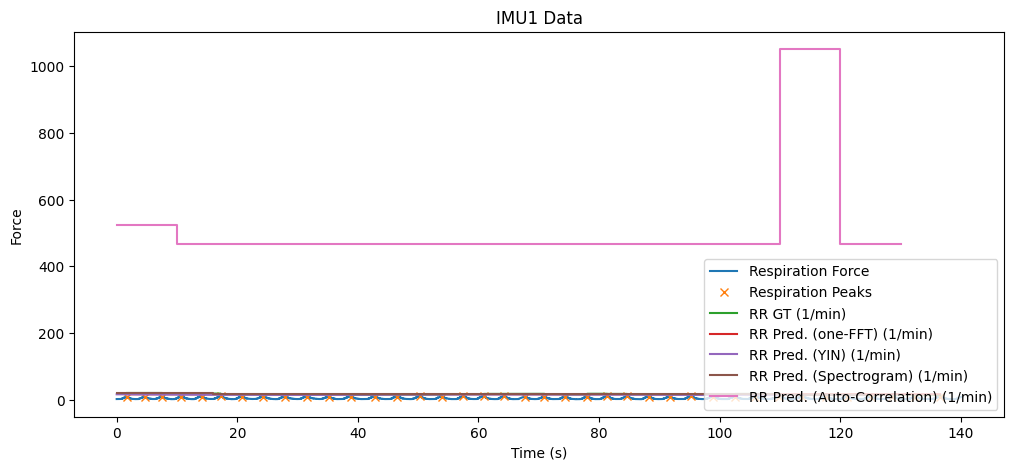

In [45]:
plt.figure(figsize=(12, 5))
# plt.figure(figsize=(12, 3))
plt.subplot(1, 1, 1)
plt.plot(
    time_ls,
    data["force"],
    label="Respiration Force", # IMU1 RMS
)

plt.plot(
    time_ls[peaks],
    data["force"].iloc[peaks],
    "x",
    label="Respiration Peaks",
)

plt.plot(
    time_ls[peaks[0]:peaks[-1]],
    gt[peaks[0]:peaks[-1]],
    label="RR GT (1/min)",
)

plt.plot(
    time_ls[peaks[0]:peaks[-1]],
    f_pred_fft_ls,
    label="RR Pred. (one-FFT) (1/min)",
)

plt.plot(
    time_f0,
    f0 * 60,
    label="RR Pred. (YIN) (1/min)",
)

plt.plot(
    t_spec_draw,
    f_spec_draw,
    label="RR Pred. (Spectrogram) (1/min)",
)

plt.plot(
    t_acf_draw,
    f_acf_draw,
    label="RR Pred. (Auto-Correlation) (1/min)",
)

plt.title("IMU1 Data")
plt.xlabel("Time (s)")
plt.ylabel("Force")
plt.legend(loc='lower right')

plt.show()

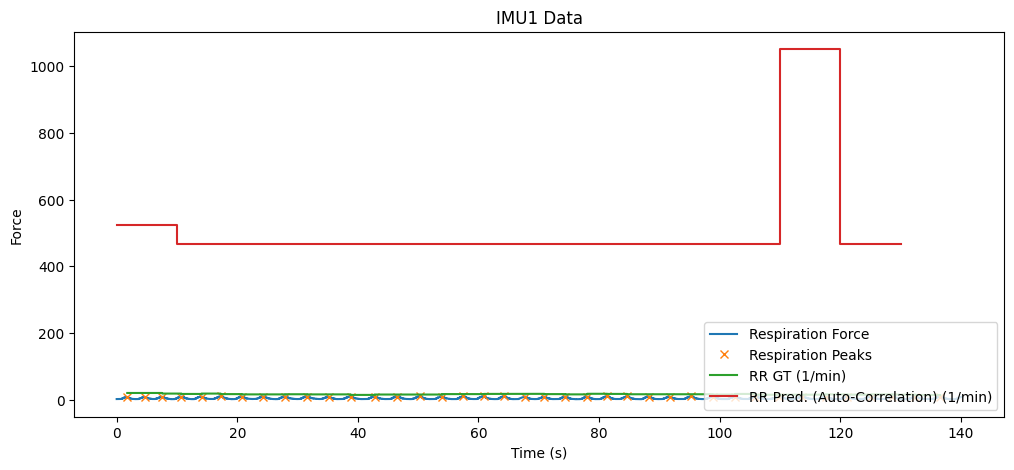

In [46]:
plt.figure(figsize=(12, 5))
# plt.figure(figsize=(12, 3))
plt.subplot(1, 1, 1)
plt.plot(
    time_ls,
    data["force"],
    label="Respiration Force", # IMU1 RMS
)

plt.plot(
    time_ls[peaks],
    data["force"].iloc[peaks],
    "x",
    label="Respiration Peaks",
)

plt.plot(
    time_ls[peaks[0]:peaks[-1]],
    gt[peaks[0]:peaks[-1]],
    label="RR GT (1/min)",
)

plt.plot(
    t_acf_draw,
    f_acf_draw,
    label="RR Pred. (Auto-Correlation) (1/min)",
)

plt.title("IMU1 Data")
plt.xlabel("Time (s)")
plt.ylabel("Force")
plt.legend(loc='lower right')

plt.show()

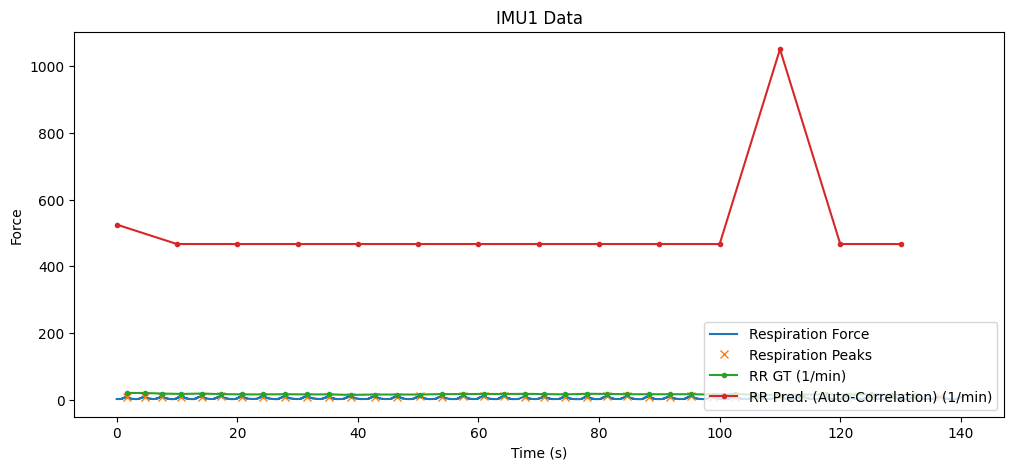

In [47]:
plt.figure(figsize=(12, 5))
# plt.figure(figsize=(12, 3))
plt.subplot(1, 1, 1)
plt.plot(
    time_ls,
    data["force"],
    label="Respiration Force", # IMU1 RMS
)

plt.plot(
    time_ls[peaks],
    data["force"].iloc[peaks],
    "x",
    label="Respiration Peaks",
)

plt.plot(
    time_ls[peaks[:-1]],
    gt_disctete,
    label="RR GT (1/min)",
    marker=".",
)

plt.plot(
    time_acf_ls,
    freq_ls1,
    label="RR Pred. (Auto-Correlation) (1/min)",
    marker=".",
)

plt.title("IMU1 Data")
plt.xlabel("Time (s)")
plt.ylabel("Force")
plt.legend(loc='lower right')

plt.show()